# Classification on mushroom dataset

### Step 0.1: Import dependecies

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Step 0.2: Reading Dataset and dropping target column and unuseful columns

In [3]:
data = pd.read_csv('./Data/mushroom_data_all.csv')

data_copy = data.copy()
#Target column
y = data_copy.class_edible
X = data_copy.drop(['class_edible'], axis = 1, inplace = False)
#Unuseful columns
X.drop(['veil-type'], axis = 1, inplace = True)

# Step 1: Splitting Dataset

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.3, random_state = 1)

# Step 2: Preprocessing dataset

### 2.1 Check on column that can be encoded

In [5]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely encoded
good_label_cols = [col for col in object_cols if set(X_train[col]) == set(X_valid[col])]

bad_label_cols = list(set(X_valid.columns)-set(good_label_cols))

print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)




Categorical columns that will be dropped from the dataset: []


### 2.2 Find which column to one_hot_encode and which to label_encode 

In [6]:
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('bruises', 2),
 ('gill-attachment', 2),
 ('gill-spacing', 2),
 ('gill-size', 2),
 ('stalk-shape', 2),
 ('ring-number', 3),
 ('cap-surface', 4),
 ('stalk-surface-above-ring', 4),
 ('stalk-surface-below-ring', 4),
 ('veil-color', 4),
 ('stalk-root', 5),
 ('ring-type', 5),
 ('cap-shape', 6),
 ('population', 6),
 ('habitat', 7),
 ('odor', 9),
 ('stalk-color-above-ring', 9),
 ('stalk-color-below-ring', 9),
 ('spore-print-color', 9),
 ('cap-color', 10),
 ('gill-color', 12)]

In [7]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in good_label_cols if X_train[col].nunique() < 10]

# Columns that will be label encoded from the dataset
high_cardinality_cols = list(set(good_label_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be label encoded from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['cap-shape', 'cap-surface', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Categorical columns that will be label encoded from the dataset: ['gill-color', 'cap-color']


### 2.3 One hot encoding 

In [8]:
oh_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

OH_cols_train = pd.DataFrame(oh_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(oh_encoder.transform(X_valid[low_cardinality_cols]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

OH_X_train = pd.concat([X_train, OH_cols_train],axis=1)
OH_X_valid = pd.concat([X_valid, OH_cols_valid],axis=1)

OH_X_train = OH_X_train.drop(low_cardinality_cols, axis=1)
OH_X_valid = OH_X_valid.drop(low_cardinality_cols, axis=1)



### 2.4 Label encoding

In [9]:
# Apply label encoder 
label_encoder = LabelEncoder()
label_OH_X_train = OH_X_train
label_OH_X_valid = OH_X_valid
for col in set(high_cardinality_cols):
    label_OH_X_train[col] = label_encoder.fit_transform(label_OH_X_train[col])
    label_OH_X_valid[col] = label_encoder.transform(label_OH_X_valid[col])

print(label_OH_X_train.columns)

Index([ 'cap-color', 'gill-color',            0,            1,            2,
                  3,            4,            5,            6,            7,
                  8,            9,           10,           11,           12,
                 13,           14,           15,           16,           17,
                 18,           19,           20,           21,           22,
                 23,           24,           25,           26,           27,
                 28,           29,           30,           31,           32,
                 33,           34,           35,           36,           37,
                 38,           39,           40,           41,           42,
                 43,           44,           45,           46,           47,
                 48,           49,           50,           51,           52,
                 53,           54,           55,           56,           57,
                 58,           59,           60,           61,           62,

# Step 3: Training Model and predicting on validation set

In [10]:
model = RandomForestClassifier(random_state = 1)
model.fit(label_OH_X_train, y_train)
predictions = model.predict(label_OH_X_valid)
print(predictions)

['e' 'p' 'p' ... 'p' 'e' 'p']


# Step 4: Accuracy

## 4.1 Confusion matrix

In [11]:
confusion_matrix= metrics.confusion_matrix(y_valid, predictions)
print(confusion_matrix)

[[1236    0]
 [   0 1202]]


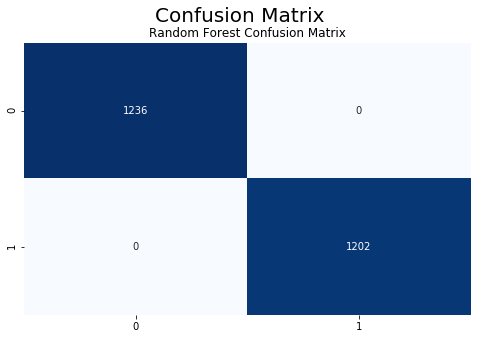

In [12]:
plt.figure(figsize=(8,5))

plt.suptitle("Confusion Matrix",fontsize=20)

plt.subplot(1,1,1)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix, cbar=False,annot=True,cmap="Blues",fmt="d")

plt.show()

## 4.2 Printing accuracy

In [13]:
training_accuracy = []
validation_accuracy = []

training_accuracy.append(model.score(label_OH_X_train, y_train))    
validation_accuracy.append(model.score(label_OH_X_valid, y_valid))

print('Training accuracy: ', training_accuracy)
print('Validation accuracy: ', validation_accuracy)

Training accuracy:  [1.0]
Validation accuracy:  [1.0]
